In [1]:
import pandas as pd 
import numpy as np 
from surprise import KNNBasic, SVD, CoClustering, Dataset, Reader
from IESEGRecSys import eval
from IESEGRecSys.model import ContentBased
from sklearn.model_selection import train_test_split

import surprise
import matplotlib.pyplot as plt

In [2]:
# Import user-rating matrix
amz = pd.read_csv('C:/Users/ffan1/OneDrive - IESEG (1)/Recommendation Systems/Individual Project/recsys-2022/train.csv')


In [3]:
# import test set
test_cf = pd.read_csv('C:/Users/ffan1/OneDrive - IESEG (1)/Recommendation Systems/Individual Project/recsys-2022/test_students.csv')

In [49]:
# inspect columns
amz.columns

Index(['userID', 'overall', 'asin', 'vote', 'reviewText', 'summary', 'style',
       'image'],
      dtype='object')

In [50]:
amz.head()

,userID,overall,asin,vote,reviewText,summary,style,image
0,13527,5.0,B0002565TI,NaN,"These filters used to be sold at PetCo, but no...",Great Place to Get Filte-rs,NaN,NaN
1,14608,2.0,B0002H3ZLM,NaN,Did not work for my large- does. Returned it.,T#wo Stars,"{'Size:': ' LARGE 60-130 LBS.', 'Color:': ' BL...",NaN
2,15536,5.0,B0009YD8OC,NaN,I was pretty skeptical that this would be easy...,stops pulling in a 6 month 60{ pound pup great!,NaN,NaN
3,12868,5.0,B001VPA9OK,NaN,Works great for groom-ing my dog. A must have.,Five /Stars,{'Color:': ' Silver'},NaN
4,181,5.0,B000K67UF2,NaN,Great cage for budgies! I cant say enough marv...,Great cage for budg{ies,"{'Size:': ' Medium', 'Pattern:': ' MO2 Cage'}",NaN


In [51]:
# number of items
print(len(amz.asin.unique()))

# number of users
print(len(amz.userID.unique()))

2310
22181


In [52]:
# check missing values
print(amz.isna().sum())

userID             0
overall            0
asin               0
vote          145992
reviewText         2
summary            1
style          29641
image         157207
dtype: int64


In [53]:
amz.shape

(161753, 8)

<AxesSubplot:>

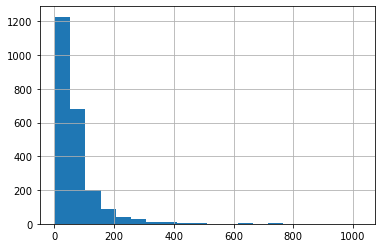

In [54]:
# Long tail
amz.asin.value_counts().clip(upper=5000).hist(bins=20)

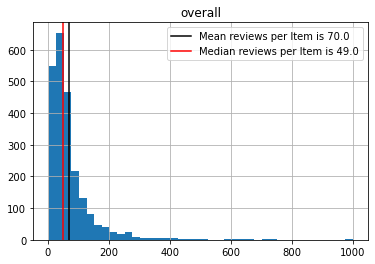

In [55]:
# average number of reviews per item
reviews_item = amz.groupby('asin').agg({'overall':'count'})

#histogram
reviews_item.clip(upper=1000).hist(bins=40)

plt.axvline(x=reviews_item.mean().item(), label=f"Mean reviews per Item is {reviews_item.mean().item():.1f}", c="k")
plt.axvline(x=reviews_item.median().item(), label=f"Median reviews per Item is {reviews_item.median().item():.1f}", c="r")
plt.legend()

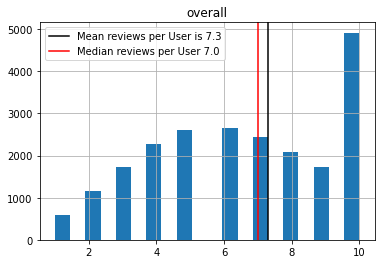

In [56]:
# average number of items rated by users
reviews_user = amz.groupby('userID').agg({'overall':'count'})

#histogram
reviews_user.clip(upper=10).hist(bins=20)

plt.axvline(x=reviews_user.mean().item(), label=f"Mean reviews per User is {reviews_user.mean().item():.1f}", c="k")
plt.axvline(x=reviews_user.median().item(), label=f"Median reviews per User {reviews_user.median().item():.1f}", c="r")
plt.legend()

In [4]:
a = np.zeros((76043, 1))
test_cf['overall'] = a
test_cf.head()

,ID,userID,asin,overall
0,21069B00BFK2B24,21069,B00BFK2B24,0.0
1,3506B00ZK0Y7R2,3506,B00ZK0Y7R2,0.0
2,21907B0002AQPA2,21907,B0002AQPA2,0.0
3,14092B0002DHXX2,14092,B0002DHXX2,0.0
4,3085B0006VB3SQ,3085,B0006VB3SQ,0.0


In [5]:
# filter columns
filter_cols = ["userID", "asin", "overall"]

train = amz[filter_cols]
test = test_cf[filter_cols]


In [6]:
print(train.shape)
print(test.shape)

(161753, 3)
(76043, 3)


In [7]:
from surprise import Dataset
from surprise import Reader

# set up reader with min rating and max rating as arguments
reader = Reader(rating_scale=(1, 5))

# surprise training and test set
df_train = Dataset.load_from_df(train, reader).build_full_trainset()
df_test = list(test.itertuples(index=False, name=None))

# User Based

#### User-Based Collaborative Filtering is a technique used to predict the items that a user might like on the basis of ratings 
#### given to that item by the other users who have similar taste with that of the target user. 
#### I chose the parameter options of k=20, min_k=5, name:'cosine'

In [57]:
from surprise import KNNBasic

# set option to cosine similarity and user-based collaborative filtering
options = {'name':'cosine', 'user_based':True}

# select 20 most similar users (min 5)
ub = KNNBasic(k=20, min_k=5, sim_options=options, random_state=42)

# fit on training set
ub.fit(df_train)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [58]:
from surprise import accuracy

ub_pred = ub.test(df_test)
accuracy.rmse(ub_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in ub_pred if i.details["was_impossible"]]) / len(ub_pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 4.3638
Impossible: 0.2701


# Item Based

#### Item-based collaborative filtering is a type of recommendation system that is based on the similarity between items calculated 
#### using the rating users have given to items.
#### I chose the parameter options of k=10, min_k=2, name:'pearson'

In [59]:
# set option to cosine similarity and item-based collaborative filtering
options = {'name':'pearson', 'user_based':False}

# select 20 most similar items (min 5)
ib = KNNBasic(k=10, min_k=2, sim_options=options, random_state=42)

# fit on training set
ib.fit(df_train)

Computing the pearson similarity matrix...
Done computing similarity matrix.


In [60]:
ib_pred = ib.test(df_test)
accuracy.rmse(ib_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in ib_pred if i.details["was_impossible"]]) / len(ib_pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 4.3611
Impossible: 0.6492


# ALS

#### ALS recommender is a matrix factorization algorithm that uses Alternating Least Squares with Weighted-Lamda-Regularization 
#### (ALS-WR). It factors the user to item matrix A into the user-to-feature matrix U and the item-to-feature matrix M : 
#### It runs the ALS algorithm in a parallel fashion.
#### I chose the parameter "method": "als", "n_epochs": 100

In [61]:
from surprise import BaselineOnly

# Select alternating least squares (ALS) and 30 epochs
options = {"method": "als", "n_epochs": 100}
als = BaselineOnly(bsl_options=options)

# fit on training set
als.fit(df_train)

als_pred = als.test(df_test)
accuracy.rmse(als_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in als_pred if i.details["was_impossible"]]) / len(als_pred)
print(f"Impossible: {perc_impossible:.4f}")

Estimating biases using als...
RMSE: 4.3460
Impossible: 0.0000


# Co_Clustering

#### Co-Clustering is a different type of algorithmic approach that exploits groups of similar users and similar items 
#### within calculated clusters.

#### I used cross validation and found good parameters to be {n_cltr_u=10, n_cltr_i=10, n_epochs=50}

In [ ]:
# cross validation to find the best parameters 

from surprise.model_selection import GridSearchCV

df_auto = Dataset.load_from_df(train, reader)

param_grid = {'n_cltr_u': [10, 20, 50],
              'n_cltr_i': [10, 20, 50],
             'n_epochs': [50, 60,100]
             }

gs = GridSearchCV(CoClustering, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(df_auto)

# combination of parameters with the best RMSE
print(gs.best_params['rmse'])
print(gs.best_score['rmse'])

In [62]:
from surprise import CoClustering

clust = CoClustering(n_cltr_u=10, n_cltr_i=10, n_epochs=50, random_state=12)

clust.fit(df_train)

In [63]:
clust_pred = clust.test(df_test)
accuracy.rmse(clust_pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in clust_pred if i.details["was_impossible"]]) / len(clust_pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 4.3733
Impossible: 0.0000


# SVD

#### Singular value decomposition shrinks the space dimension from N-dimension to K-dimension (where K<N) and reduces the number of features. 
#### SVD constructs a matrix with the row of users and columns of items and the elements are given by the users’ ratings. 
#### SVD decomposes a matrix into three other matrices and extracts the factors from the factorization of a high-level 
#### (user-item-rating) matrix.

#### I used cross validation and found good parameters to be {'n_factors': 5}

In [8]:
# cross validation to find the best parameters 

from surprise.model_selection import GridSearchCV

df_auto = Dataset.load_from_df(train, reader)

param_grid = {'n_factors': [5,20,50,75,100,500]}

gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3)

gs.fit(df_auto)

# combination of parameters with the best RMSE
print(gs.best_params['rmse'])
print(gs.best_score['rmse'])

{'n_factors': 5}
1.080627363555121


In [11]:
from surprise import accuracy

algo = gs.best_estimator['rmse']
algo.fit(df_train)

pred = algo.test(df_test)
accuracy.rmse(pred)

# percentage impossible predictions
perc_impossible = np.sum([1 for i in pred if i.details["was_impossible"]]) / len(pred)
print(f"Impossible: {perc_impossible:.4f}")

RMSE: 4.3505
Impossible: 0.0000


In [ ]:
# export to Excel

In [38]:
preddf = pd.DataFrame(pred)

In [39]:
preddf = preddf[['uid','iid','est']]

In [40]:
preddf

,uid,iid,est
0,21069,B00BFK2B24,3.342481
1,3506,B00ZK0Y7R2,3.601445
2,21907,B0002AQPA2,4.067562
3,14092,B0002DHXX2,4.378355
4,3085,B0006VB3SQ,4.298012
...,...,...,...
76038,9343,B004GFN2ZA,4.264787
76039,17932,B000JZOQO2,4.370520
76040,14272,B005440HLO,3.866691
76041,11151,B0002VAZSY,4.178537


In [41]:
preddf["ID"] = preddf['uid'].astype(str) + preddf['iid'].astype(str) 

In [42]:
preddf 


,uid,iid,est,ID
0,21069,B00BFK2B24,3.342481,21069B00BFK2B24
1,3506,B00ZK0Y7R2,3.601445,3506B00ZK0Y7R2
2,21907,B0002AQPA2,4.067562,21907B0002AQPA2
3,14092,B0002DHXX2,4.378355,14092B0002DHXX2
4,3085,B0006VB3SQ,4.298012,3085B0006VB3SQ
...,...,...,...,...
76038,9343,B004GFN2ZA,4.264787,9343B004GFN2ZA
76039,17932,B000JZOQO2,4.370520,17932B000JZOQO2
76040,14272,B005440HLO,3.866691,14272B005440HLO
76041,11151,B0002VAZSY,4.178537,11151B0002VAZSY


In [43]:
preddf['overall'] = preddf['est']

In [44]:
preddf

,uid,iid,est,ID,overall
0,21069,B00BFK2B24,3.342481,21069B00BFK2B24,3.342481
1,3506,B00ZK0Y7R2,3.601445,3506B00ZK0Y7R2,3.601445
2,21907,B0002AQPA2,4.067562,21907B0002AQPA2,4.067562
3,14092,B0002DHXX2,4.378355,14092B0002DHXX2,4.378355
4,3085,B0006VB3SQ,4.298012,3085B0006VB3SQ,4.298012
...,...,...,...,...,...
76038,9343,B004GFN2ZA,4.264787,9343B004GFN2ZA,4.264787
76039,17932,B000JZOQO2,4.370520,17932B000JZOQO2,4.370520
76040,14272,B005440HLO,3.866691,14272B005440HLO,3.866691
76041,11151,B0002VAZSY,4.178537,11151B0002VAZSY,4.178537


In [46]:
preddf = preddf[['ID','overall']]

In [47]:
preddf

,ID,overall
0,21069B00BFK2B24,3.342481
1,3506B00ZK0Y7R2,3.601445
2,21907B0002AQPA2,4.067562
3,14092B0002DHXX2,4.378355
4,3085B0006VB3SQ,4.298012
...,...,...
76038,9343B004GFN2ZA,4.264787
76039,17932B000JZOQO2,4.370520
76040,14272B005440HLO,3.866691
76041,11151B0002VAZSY,4.178537


In [48]:
preddf.to_csv(r'C:\Users\ffan1\OneDrive - IESEG (1)\Recommendation Systems\Individual Project\Exports\1.csv',index=False)

# Hybrid Model 1: Hybrid_svd_coclustering

In [65]:
# Combine predictions (mean)

# extract predictions SVD and Co_Clustering
df_pred, df_pred_clust = pd.DataFrame(pred), pd.DataFrame(clust_pred)

In [67]:
df_hybrid = df_pred.copy()

In [68]:
df_hybrid['est'] = (np.array(df_pred['est']) + np.array(df_pred_clust['est'])) / 2

df_hybrid.head()

,uid,iid,r_ui,est,details
0,21069,B00BFK2B24,0.0,3.176525,{'was_impossible': False}
1,3506,B00ZK0Y7R2,0.0,3.441187,{'was_impossible': False}
2,21907,B0002AQPA2,0.0,4.127640,{'was_impossible': False}
3,14092,B0002DHXX2,0.0,4.550528,{'was_impossible': False}
4,3085,B0006VB3SQ,0.0,4.509390,{'was_impossible': False}


In [69]:
hb_svd_clust = eval.evaluate(df_hybrid, topn=5, rating_cutoff=5).rename(columns={'value':'Hybrid_SVD_CoClustering'})
hb_svd_clust

C:\Users\ffan1\OneDrive - IESEG (1)\Recommendation Systems\Individual Project\IESEGRecSys\eval.py:146: RuntimeWarning: invalid value encountered in long_scalars
  recall    = TP / (TP+FN)


,Hybrid_SVD_CoClustering
RMSE,4.349262
MAE,4.307986
Recall,NaN
Precision,0.000000
F1,NaN
NDCG@5,0.846328


In [70]:
# export to Excel submission

df_hybrid = df_hybrid[['uid','iid','est']]
df_hybrid["ID"] = df_hybrid['uid'].astype(str) + df_hybrid['iid'].astype(str) 
df_hybrid['overall'] = df_hybrid['est']
df_hybrid = df_hybrid[['ID','overall']]
df_hybrid.to_csv(r'C:\Users\ffan1\OneDrive - IESEG (1)\Recommendation Systems\Individual Project\Exports\4.csv',index=False)

# Improvements and Conclusions

#### Each algorithm is cross validated to find the best parameters, and then evaluated based on RMSE. 
#### The RMSE results on this Jupyter Notebook (above 4.0) for all algorithms do not match with my Kaggle submission RMSE.
#### Since all my Kaggle submission RMSEs are between the 1.03 - 1.06 range, the best Kaggle submission is 1.03631.
#### Further investigation is needed to determine the discrepancy between my test RMSE here and RMSE on Kaggle.
#### Possible reasons: difference of random state; different samples of test set, thank you.

#### Sources:
#### https://surprise.readthedocs.io/en/stable/model_selection.html
#### https://surprise.readthedocs.io/en/stable/getting_started.html#grid-search-note
#### https://surprise.readthedocs.io/en/stable/getting_started.html